# 全人類がわかるディープラーニング Day2演習（解答）

## 概要

本演習では深層学習の基礎である正則化に関する内容を穴埋め形式で実装します。なお、予め用意されたコード（訓練用・テスト用データの取得、ミニバッチ学習など）はそのまま使用し、指示された穴埋め部を編集してください。
演習問題は全6問、問題文は<font color="Red">赤字</font>です。

所要時間：2~5時間

### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [1]:
import csv
import os
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split


# 乱数シードを指定
np.random.seed(seed=0)

### データの読み込み・線形結合層などの定義

Day1演習と共通しているので、読み飛ばしていただいて構いません。

In [2]:
# mnistデータセットのロード(ネットワーク接続が必要・少し時間がかかります)
if os.path.exists('mnist_784'):
    with open('mnist_784','rb') as f:
        mnist = pickle.load(f)
else:
    mnist = datasets.fetch_openml('mnist_784')
    with open('mnist_784', 'wb') as f:
        pickle.dump(mnist, f)
    
# 画像とラベルを取得
X, T = mnist.data, mnist.target
# 訓練データとテストデータに分割
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2)
# ラベルデータをint型にし、one-hot-vectorに変換します
T_train = np.eye(10)[T_train.astype("int")]
T_test = np.eye(10)[T_test.astype("int")]

In [3]:
class FullyConnectedLayer():
    def __init__(self, input_shape, output_shape):
        self.w = np.random.randn(input_shape, output_shape) * 0.01
        self.b = np.zeros(output_shape, dtype=np.float)
        self.x = None
        self.dw = None
        self.db = None
        
    def __call__(self, x):
        self.x = x
        out = np.dot(self.x, self.w) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.w.T)
        batch_size = dx.shape[0]
        self.dw = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

In [4]:
class SoftmaxCrossEntropyLoss():
    def __init__(self):
        self.y = None
        self.t = None
        self.loss = None
        
    def __call__(self, t, y):
        self.y = softmax(y)
        self.t = t.copy()
        self.loss = cross_entropy_error(self.t, self.y)
        return self.loss
    
    def backward(self):
        batch_size = self.t.shape[0]
        dy = self.y - self.t
        dy /= batch_size
        return dy

In [5]:
def softmax(x):
    x = x.T
    _x = x - np.max(x, axis=0)
    _x = np.exp(_x) / np.sum(np.exp(_x), axis=0)
    return _x.T

In [6]:
def cross_entropy_error(t, y):
    delta = 1e-8
    error = -np.mean(t * np.log(y + delta))
    return error

In [7]:
class ReLU():
    def __init__(self):
        self.mask = None

    def __call__(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

### ドロップアウト

1. <font color="Red">ドロップアウトクラスを完成させてください。</font>
    - 入力されてきた ```x``` に対し、確率 ```dropout_ratio``` で出力を0にする。
ヒント：xと同じサイズの乱数

In [8]:
class Dropout():
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def __call__(self, x, train_flg=True):
        if train_flg:
            randommatrix = np.random.rand(*x.shape)
            self.mask = randommatrix > self.dropout_ratio#### 問1 ####
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

### パラメータノルムペナルティ

2-1. <font color="Red">ベクトル・行列に対してLpノルムを計算する関数```lp_norm```を完成させなさい。</font>
    - xはnumpyの任意の長さの配列を使用できるようにする。
    - 使用出来るnumpyの関数はabsとsumのみとする。  


In [9]:
def lp_norm(x, p=2):
    return (np.sum(np.abs(x)**p))**(1/p)#### 問2-1 ####

2-2. <font color="Red">```dropout```クラスと```lp_norm```関数を使用し、ドロップアウトとL2ノルム正則化（重み減衰）を含めた以下のネットワークを完成させなさい。</font>

- 損失関数に $ \frac{\lambda}{2}\|w\|_2^2 $を正則化項として加える。

In [10]:
class MLP_classifier():

    def __init__(self, weight_decay_lambda=0):
        '''
        構造
        x -> fc(783, 256) -> relu -> dropout -> fc(256, 256) -> relu -> dropout -> fc(256, 10) -> out
        '''
        
        # 層の定義
        self.fc1 = FullyConnectedLayer(784, 256)
        self.relu1 = ReLU()
        self.dropout1 = Dropout()
        self.fc2 = FullyConnectedLayer(256, 256)
        self.relu2 = ReLU()
        self.dropout2 = Dropout()
        self.fc3 = FullyConnectedLayer(256, 10)
        self.out = None
        
        # 損失関数の定義
        self.criterion = SoftmaxCrossEntropyLoss()
        self.weight_decay_lambda = weight_decay_lambda

    def forward(self, x, train_flg=True):
        '''
        順伝播
        '''
        
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x, train_flg)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x, train_flg)
        self.out = self.fc3(x)
        
        # 勾配計算の都合上softmaxはこの順伝播関数内では行わない
        # 予測するときはさらにsoftmaxを通す必要がある
        return self.out
    
    def loss(self, x, t):
        loss = self.criterion(t, self.forward(x))
        for fc in [self.fc1, self.fc2, self.fc3]:
            loss += 0.5*self.weight_decay_lambda*lp_norm(fc.w,2)**2#### 問2-2-1　####
        return loss

    def backward(self):
        '''
        逆伝播
        '''
        # 勾配を逆伝播
        d = self.criterion.backward()
        d = self.fc3.backward(d)
        d = self.dropout2.backward(d)
        d = self.relu2.backward(d)
        d = self.fc2.backward(d)
        d = self.dropout1.backward(d)
        d = self.relu1.backward(d)
        d = self.fc1.backward(d)
        
        for fc in [self.fc1, self.fc2, self.fc3]:
            fc.dw += self.weight_decay_lambda*fc.w#### 問2-2-2 ####

    def optimize_GradientDecent(self, lr):
        '''
        勾配降下法による全層のパラメータの更新
        '''
        for fc in [self.fc1, self.fc2, self.fc3]:
            fc.w -= lr * fc.dw
            fc.b -= lr * fc.db

### 学習
train_loss が1.4前後、accuracyが80%前後になっていれば学習成功です。

今回はモデルが単純なので、重み減衰やドロップアウトを加えてもあまり効果を実感できませんが、CNNなどの複雑なモデルになると正則化処理は必須になてきます。

In [11]:
# モデルの宣言
model = MLP_classifier(weight_decay_lambda=0.1)

# 学習率
lr = 0.02
# 学習エポック数
n_epoch = 30

# n_epoch繰り返す
for n in range(n_epoch):
    loss = model.loss(X_train, T_train)    
    model.backward()
    
    model.optimize_GradientDecent(lr)
        
    # テスト
    y = model.forward(X_test, train_flg=False)
    pred = softmax(y)
    accuracy = np.mean(np.equal(np.argmax(y, axis=1), np.argmax(T_test, axis=1)))
    
    print(f'EPOCH {n + 1} | TRAIN LOSS {loss:.5f} | ACCURACY {accuracy:.2%}')

EPOCH 1 | TRAIN LOSS 1.57379 | ACCURACY 19.41%
EPOCH 2 | TRAIN LOSS 1.56571 | ACCURACY 29.18%
EPOCH 3 | TRAIN LOSS 1.55825 | ACCURACY 37.47%
EPOCH 4 | TRAIN LOSS 1.55084 | ACCURACY 43.16%
EPOCH 5 | TRAIN LOSS 1.54349 | ACCURACY 47.99%
EPOCH 6 | TRAIN LOSS 1.53618 | ACCURACY 51.86%
EPOCH 7 | TRAIN LOSS 1.52864 | ACCURACY 55.35%
EPOCH 8 | TRAIN LOSS 1.52106 | ACCURACY 58.36%
EPOCH 9 | TRAIN LOSS 1.51311 | ACCURACY 61.25%
EPOCH 10 | TRAIN LOSS 1.50461 | ACCURACY 63.52%
EPOCH 11 | TRAIN LOSS 1.49584 | ACCURACY 65.43%
EPOCH 12 | TRAIN LOSS 1.48692 | ACCURACY 67.10%
EPOCH 13 | TRAIN LOSS 1.47694 | ACCURACY 68.45%
EPOCH 14 | TRAIN LOSS 1.46680 | ACCURACY 69.31%
EPOCH 15 | TRAIN LOSS 1.45661 | ACCURACY 70.41%
EPOCH 16 | TRAIN LOSS 1.44611 | ACCURACY 71.56%
EPOCH 17 | TRAIN LOSS 1.43593 | ACCURACY 72.55%
EPOCH 18 | TRAIN LOSS 1.42626 | ACCURACY 73.66%
EPOCH 19 | TRAIN LOSS 1.41661 | ACCURACY 74.61%
EPOCH 20 | TRAIN LOSS 1.40783 | ACCURACY 75.64%
EPOCH 21 | TRAIN LOSS 1.39989 | ACCURACY 76.33%
E

### データ拡張
以下のコードを活用し、各問題で指定された画像変換を行う関数を作り、次で読み込んだ画像（image）を元に拡張データを作り表示するプログラムを作りなさい。

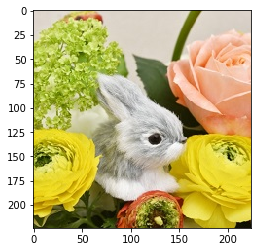

画素数とチャンネル数： (224, 224, 3)
[[[220 211 204]
  [220 211 204]
  [220 211 204]
  ...
  [220 211 202]
  [219 210 201]
  [219 210 201]]

 [[220 211 204]
  [221 212 205]
  [221 212 205]
  ...
  [220 211 202]
  [219 210 201]
  [219 210 201]]

 [[221 212 205]
  [222 213 206]
  [222 213 206]
  ...
  [220 211 202]
  [220 211 202]
  [219 210 201]]

 ...

 [[ 69  76  35]
  [ 71  77  33]
  [ 60  63  10]
  ...
  [ 15  16   0]
  [ 16  17   0]
  [ 13  14   0]]

 [[ 59  68  21]
  [ 51  61  11]
  [ 52  62  12]
  ...
  [ 15  16   0]
  [ 15  15   3]
  [ 14  14   6]]

 [[ 57  70  17]
  [ 56  68  18]
  [ 49  63  14]
  ...
  [ 17  16   0]
  [ 14  14   6]
  [ 14  13   9]]]


In [12]:
# numpyで画像処理を行う準備
import numpy as np
from PIL import Image
# 画像読み込み(224×224ピクセルのサンプル画像)
image = np.array(Image.open('./img/rabbit.jpg'))
# 画像表示のためにmatplotlibを利用
from matplotlib import pylab as plt
# 原画像の表示
plt.imshow( image )
plt.show()
# 出力される
print("画素数とチャンネル数：",image.shape)
# 画像のデータ
print(image)

3. <font color="Red">画像のRGBを反転させる関数 __get_negative__ を作り、imageの画像のネガティブ画像を生成し表示しなさい。</font>
    - 引数は画像（image）のみとする  
    - 引数として与えられた画像のネガティブ画像を戻り値として返す
    - ただし、引数として与えられた元の画像は変化させないこと  
ヒント:画素の成分の最大値は255。最大値から画素の値を引いた値がネガティブな画素の値となる  

![実行結果：ネガティブ画像](img/negative.png)  

ネガティブ画像


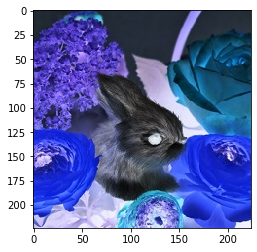

In [13]:
def get_negative(image):
    # イメージをコピー
    new_image = image.copy()
    new_image = 255-new_image###### 問3 ######
    return new_image

print("ネガティブ画像")
image_2 = get_negative(image)
plt.imshow( image_2 )
plt.show()

4-1,2,3. <font color="Red">画像からR,G,Bのうち指定したチャンネルの画像を取得する関数 __get_channel__ を作り、imageの画像のR成分、G成分、B成分のチャンネルの画像を生成し表示なさい。</font>
    - 引数は2つ。第一引数は画像（image）、第二引数にはチャンネルを指定する  
    - チャンネルの指定は「channel='r'」とすることにより赤、「channel='g'」とすることにより緑、channel='b'」とすることにより青のチャネルの画像が取得できるものとする。
    - それ以外のチャンネルが指定された場合は元の画像と同じ画像を出力する
    - ただし、引数として与えられた元の画像は変化させないこと
ヒント:指定された画素のチャンネルのみの画像を生成するためには、それ以外の値を0とする。例えば、channel='r'とした場合は、Rのみを残し、G,Bの値は0にする。  
![実行結果：REDチャンネル画像](img/red.png)
![実行結果：GREENチャンネル画像](img/green.png)     
![実行結果：BLUEチャンネル画像](img/blue.png) 



REDチャンネル


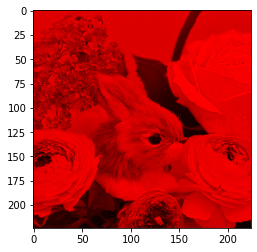

GREENチャンネル


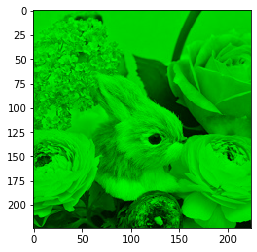

BLUEチャンネル


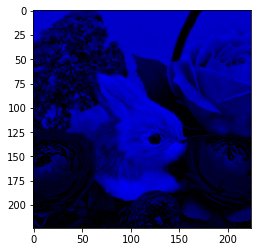

In [14]:
def get_channel(image,channel='r'):
    # イメージをコピー
    new_image = image.copy()
    if channel=='r':
        # 「r」が指定された場合、「g」「b」は0にする
        new_image[:,:,1]=0###### 問4-1 ###### = 0
        new_image[:,:,2]=0###### 問4-2 ###### = 0
    elif channel=='g':
         # 「g」が指定された場合、「r」「b」は0にする
        new_image[:,:,0]=0###### 問4-3 ###### = 0
        new_image[:,:,2]=0###### 問4-2 ###### = 0
    elif channel=='b':
         # 「g」が指定された場合、「r」「b」は0にする
        new_image[:,:,0]=0###### 問4-3 ###### = 0
        new_image[:,:,1]=0###### 問4-1 ###### = 0  
    return new_image


print("REDチャンネル")
image_2 = get_channel(image,channel='r')
plt.imshow( image_2 )
plt.show()

print("GREENチャンネル")
image_2 = get_channel(image,channel='g')
plt.imshow( image_2 )
plt.show()

print("BLUEチャンネル")
image_2 = get_channel(image,channel='b')
plt.imshow( image_2 )
plt.show()

5. <font color="Red">R,G,B画像をグレースケールに変換する __get_channel__ 関数を完成させなさい。グレースケールの画素の計算方法は、R,G,Bそれぞれのチャンネルの画素の平均をとるものとする。</font>
    - 引数は画像（image）のみとする  
    - 引数として与えられた画像をグレイスケール画像にしたものを戻り値として返す
    - ただし、引数として与えられた元の画像は変化させないこと
![実行結果：GRAY画像](img/gray.png) 

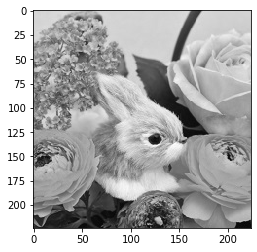

In [15]:
def get_gray(img):
    img2 = img.copy()
    img2[:, :, 0] = np.average(img,axis=2)###### 問5 ######
    img2[:, :, 1] = np.average(img,axis=2)###### 問5 ######
    img2[:, :, 2] = np.average(img,axis=2)###### 問5 ######
    return img2
plt.imshow( get_gray(image) )
plt.show()

6. <font color="Red">画像にランダムノイズを指定する関数 __rand_noize__ 関数を完成させなさい。第一引数は画像、第二引数seedは乱数の種、第三引数pixelsは発生させるノイズのピクセル数とする。この関数を用いると元画像に指定した数だけ白いピクセルをランダムな位置に配置することができる。</font>
    - 乱数の種の値は0とする
    - ランダムノイズの発生数を1000とする  
![実行結果：ランダムノイズ画像](img/rand_noise.png) 

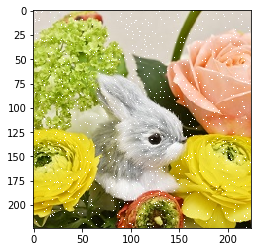

In [16]:
def rand_noize(img, seed, pixels):
    np.random.seed(seed)
    img2 = img.copy()
    for _ in range(pixels):
        x = np.random.randint(0, img.shape[0])
        y = np.random.randint(0, img.shape[1])
        img2[x,y,:]=255###### 問6 ###### = 255.
    return img2

plt.imshow( rand_noize(image, 0, 1000) )
plt.show()